### Factor Analysis

&nbsp;

Factor Analysis is another model solved by Expectation Maximization algorithm (we already have Gaussian Mixture Model and Naive Bayes Mixture Model). It is related to Principal Component Analysis as it is a generalized version of Probabilistic PCA. Although both PCA and FA work on dimension reduction, FA has the capability to detect the latent variable structure from the perspective of distribution.

Unfortunately, there aren't many towardsdatascience articles on FA due to its complexity in derivation. You can read the paper by Ghahramani and Hinton in 1996 as an alternative material for Stanford University (though they offer a slightly different version of derivation).

FA in sklearn uses a different approach called singular value decomposition. EM is slower than SVD due to the increasing computation in log likelihood (Barber 2012). For those of you who are interested in SVD implementation of FA, you can refer to the free textbook hosted on the server of UCL.

http://web4.cs.ucl.ac.uk/staff/D.Barber/pmwiki/pmwiki.php?n=Brml.Online

Alternative FA material

http://www.cs.utoronto.ca/~hinton/absps/tr-96-1.pdf

Reference to PCA

https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb
    

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.decomposition

In [2]:
#official sklearn factor analysis
def skl_fa(data,num_of_latents):
    
    clf=sklearn.decomposition.FactorAnalysis(num_of_latents)    
    clf.fit(data)
       
    return clf

In [3]:
#pdf of multivariate gaussian
#equivalent to scipy.stats.multivariate_normal(miu,sigma).pdf(data)
def multivariate_gaussian(data,miu,sigma):
    
    numerator=np.exp(-0.5*(data-miu)@np.linalg.inv(sigma)@(data-miu).T)
    denominator=(2*np.pi)**(data.shape[1]/2)*np.linalg.det(sigma)**0.5

    return np.diagonal(numerator/denominator)

In [4]:
#e step
#use lambda_ and psi to update conditional miu and sigma
def e_step(data,miu,lambda_,psi):
    
    #denote beta
    beta=lambda_.T@np.linalg.inv(lambda_@lambda_.T+psi)

    #compute conditional params
    miu_z_given_x=beta@(data-miu).T
    sigma_z_given_x=np.identity(lambda_.shape[1])-beta@lambda_
    
    return miu_z_given_x,sigma_z_given_x

In [5]:
#m step
#use conditional miu and sigma to update lambda_,psi
def m_step(data,miu,miu_z_given_x,sigma_z_given_x):

    #equation 8 in stanford material
    lambda_=(data-miu).T@miu_z_given_x.T@np.linalg.inv(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)

    #last equation
    phi=(data.T@data-2*data.T@miu_z_given_x.T@lambda_.T+ \
         lambda_@(miu_z_given_x@miu_z_given_x.T+sigma_z_given_x)@lambda_.T)/data.shape[0]
    
    #take diagonal
    psi=np.diag(np.diag(phi))
    
    return lambda_,psi

In [6]:
#get latent variables z
#andrew ng didnt teach us how to get the latent
#we have to borrow ideas from sklearn even though we dont know why
#alternatively
#x=miu+lambda_@z+epsilon
#z=inverse(lambda_)@(x-miu-epsilon)
#but this is incorrect
#as we dont know epsilon
#we can only assume its zero
#z=np.linalg.pinv(lambda_)@(data-miu).T
def get_latent(data,miu,lambda_,psi):
    
    weighted_psi=lambda_.T@np.linalg.inv(psi)
    cov_z=np.linalg.inv(np.identity(lambda_.shape[1])+weighted_psi@lambda_)
    z=(data-miu)@(weighted_psi).T@cov_z
    
    return z

In [7]:
#unlike gmm, only p(x|z) depends on the params
#thus the computation can be simplified
#although we have one more step of computing z
def get_lower_bound(data,miu,lambda_,psi):
    
    #transform x
    z=get_latent(data,miu,lambda_,psi)

    #logarithm multivariate gaussian
    logpdf=np.log(multivariate_gaussian(data-(lambda_@z.T).T,miu,psi))    
    lower_bound=sum(logpdf)
    
    return lower_bound

In [8]:
#using mle for training
def training(data,num_of_latents,
             tolerance=0.001,num_of_itr=50,diagnosis=False):
        
    #get dimensions
    num_of_features=data.shape[1]
    
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    
    #miu is the unconditional mean
    miu=data.mean(axis=0)    
    
    #lambda_ is the coefficient of the latent variables
    #use principal components to initialize
    #this approach improves the performance (Barber 2012)
    _,eigvecs=np.linalg.eig((data-miu).T@(data-miu)/data.shape[0])
    lambda_=eigvecs[:,:num_of_latents]

    #psi is the covariance matrix of noise, a diagonal matrix
    #use the diagonal of covariance matrix to initialize
    psi=np.diag(np.diag((data-miu).T@(data-miu)/data.shape[0]))  

    #cap the maximum number of iterations
    while counter<num_of_itr:
        
        #e step
        miu_z_given_x,sigma_z_given_x=e_step(data,miu,lambda_,psi)
            
        #m step
        lambda_,psi=m_step(data,miu,
                           miu_z_given_x,
                           sigma_z_given_x)
            
        #use lower bound to determine if converged
        lower_bound_old=lower_bound
        lower_bound=get_lower_bound(data,miu,lambda_,psi)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return miu_z_given_x,sigma_z_given_x,lambda_,psi
            
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return miu_z_given_x,sigma_z_given_x,lambda_,psi

In [9]:
#initialize number of latent variables
num_of_latents=2

In [10]:
#load data
iris=sklearn.datasets.load_iris()

In [11]:
#raise error when zero is encountered in logarithm
np.seterr(divide='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [12]:
miu_z_given_x,sigma_z_given_x,lambda_,psi=training(iris.data,
                                                   num_of_latents,
                                                   diagnosis=True)

3 iterations to reach convergence



In [13]:
clf=skl_fa(iris.data,num_of_latents)

In [14]:
#both lambda and psi seem to be different from the result of sklearn
print(lambda_)
print(clf.components_.T)
print(psi)
print(np.diag(clf.noise_variance_))

[[ 2.51538355 -1.81399954]
 [-0.59921545 -3.44747338]
 [ 6.20068532  0.83567308]
 [ 2.70348799 -0.22529923]]
[[ 0.72746132 -0.36874572]
 [-0.18085204 -0.24059   ]
 [ 1.75790224  0.03551754]
 [ 0.73100458  0.04526567]]
[[34.3143796   0.          0.          0.        ]
 [ 0.          9.41287335  0.          0.        ]
 [ 0.          0.         14.24159276  0.        ]
 [ 0.          0.          0.          1.45144496]]
[[0.01609026 0.         0.         0.        ]
 [0.         0.09807659 0.         0.        ]
 [0.         0.         0.00405033 0.        ]
 [0.         0.         0.         0.04071555]]


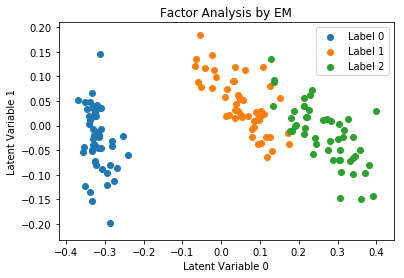

In [15]:
#viz
z_em=get_latent(iris.data,iris.data.mean(axis=0),lambda_,psi)

for i in np.unique(iris.target):
    plt.scatter(z_em[:,0][iris.target==i],
                z_em[:,1][iris.target==i],
                label=f'Label {i}')
plt.legend()
plt.title('Factor Analysis by EM')
plt.xlabel('Latent Variable 0')
plt.ylabel('Latent Variable 1')
plt.show()

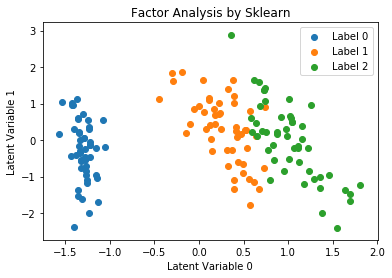

In [16]:
#our implementation looks like a flipped version
#kinda like pca
z_skl=clf.transform(iris.data)

for i in np.unique(iris.target):
    plt.scatter(z_skl[:,0][iris.target==i],
                z_skl[:,1][iris.target==i],
                label=f'Label {i}')
plt.legend()
plt.title('Factor Analysis by Sklearn')
plt.xlabel('Latent Variable 0')
plt.ylabel('Latent Variable 1')
plt.show()

### Optimal Number of Factors

&nbsp;

The optimal number of factors is somewhat similar to PCA. In our case, we already know the number because we merely want to make 2D visualization. For a more general case of latent variable transformation, the optimal could be determined by a couple of different methods. Here, we merely talk about three simple but powerful methods (basically they are related to eigenvalues).

* Kaiser Criterion
* Scree Plot
* Variance Explained Criteria

Other methods can be found in Wikipedia

https://en.wikipedia.org/wiki/Factor_analysis#Criteria_for_determining_the_number_of_factors

In [17]:
#get eigenvalues via LAPACK
miu=iris.data.mean(axis=0)
eigvals,eigvecs=np.linalg.eig((iris.data-miu).T@(iris.data-miu)/iris.data.shape[0])  

##### Kaiser Criterion

&nbsp;

Don't get overwhelmed by the buzzword. The criterion can be described within 10 words, drop all components with eigenvalues smaller than 1.

In [18]:
print(f'The optimal number of factors suggested by Kaiser Criterion is {eigvals[eigvals>1].shape[0]}')

The optimal number of factors suggested by Kaiser Criterion is 1


##### Scree Plot

&nbsp;

Scree plot is plotting eigenvalues against the number of features. Then we use elbow method to determine where the steepest drop is.

More details of elbow method can be found in the link below

https://github.com/je-suis-tm/machine-learning/blob/master/k%20means.ipynb

In [19]:
#dual axis plot
def dual_axis_plot(xaxis,data1,data2,fst_color='r',
                    sec_color='b',
                   x_label='',y_label1='',y_label2='',
                   legend1='',legend2='',grid=False,title=''):
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label1, color=fst_color)
    ax.plot(xaxis, data1, color=fst_color,label=legend1)
    ax.tick_params(axis='y',labelcolor=fst_color)
    ax.yaxis.labelpad=15

    plt.legend(loc=3)
    ax2 = ax.twinx()

    ax2.set_ylabel(y_label2, color=sec_color,rotation=270)
    ax2.plot(xaxis, data2, color=sec_color,label=legend2)
    ax2.tick_params(axis='y',labelcolor=sec_color)
    ax2.yaxis.labelpad=15

    fig.tight_layout()
    plt.legend(loc=4)
    plt.grid(grid)
    plt.xticks(xaxis)
    plt.title(title)
    plt.show()

In [20]:
#get distance between a point and a line
def get_distance(x,y,a,b):
    
    numerator=y-x*a-b
    denominator=(a**2+1)**0.5
    
    return np.abs(numerator/denominator)

#create line equation from two points
def get_line_params(x1,y1,x2,y2):
    
    a=(y1-y2)/(x1-x2)
    b=y1-a*x1
    
    return a,b

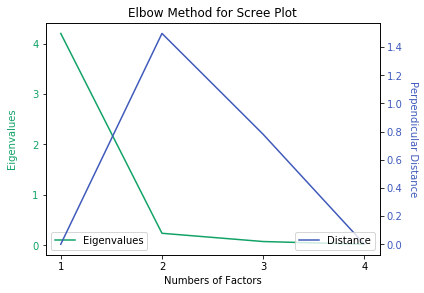

In [21]:
#elbow method
a,b=get_line_params(0,eigvals[0],len(eigvals)-1,eigvals[-1])

distance=[]
for i in range(len(eigvals)):    
    distance.append(get_distance(i,eigvals[i],a,b))

dual_axis_plot(np.arange(1,len(distance)+1),eigvals,distance,
               x_label='Numbers of Factors',
               y_label1='Eigenvalues',
               y_label2='Perpendicular Distance',
               legend1='Eigenvalues',legend2='Distance',
               title='Elbow Method for Scree Plot',
               fst_color='#11a266',sec_color='#405abb')

In [22]:
#apparently different approaches end up with different results
print(f'The optimal number of factors suggested by Scree Plot is {distance.index(max(distance))+1}')

The optimal number of factors suggested by Scree Plot is 2


##### Variance Explained Criteria

&nbsp;

This is the same as PCA. The R squared (usually 95% in statistics) exceeding the preset threshold is the optimal number of factors.

In [23]:
#compute variance explained
def compute_r_squared(data,z,miu,lambda_):

    #compute fitted and error
    fitted=lambda_@z.T+miu.reshape(-1,1)
    error=(data-fitted.T)

    #sum of squared errors
    #equivalent to np.linalg.norm(error)
    numerator=np.diag(error.T@error).sum()**0.5

    #sum of squared total
    denominator=np.diag((data).T@(data)).sum()**0.5

    return 1-numerator/denominator

In [24]:
#iterate through all possible numbers of factors
rsquared=[]
threshold=0.95
for i in range(1,iris.data.shape[1]+1):
    _,_,lambda_,psi=training(iris.data,i)
    z=get_latent(iris.data, miu, lambda_, psi)
    rsquared.append(compute_r_squared(iris.data,z,miu,lambda_))

In [25]:
#find the optima
try:
    optima=[i for i in rsquared if i>threshold][0]
    ind=rsquared.index(optima)+1
except IndexError:
    ind=len(rsquared)-1

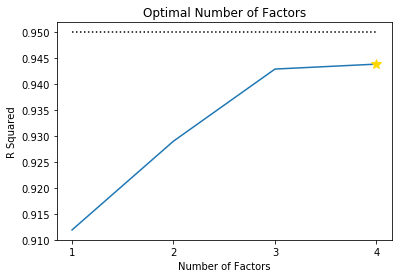

In [26]:
#viz
plt.plot(range(1,iris.data.shape[1]+1),rsquared)
plt.plot([ind+1],[rsquared[ind]],lw=0,marker='*',
         markersize=10,color='gold') 
plt.hlines(threshold,1,iris.data.shape[1],linestyles=':')
plt.xticks(range(1,iris.data.shape[1]+1))
plt.title('Optimal Number of Factors')
plt.xlabel('Number of Factors')
plt.ylabel('R Squared')
plt.show()

In [27]:
#apparently nobody hits the threshold, lol
print(f'The optimal number of factors suggested by Variance Explained Criteria is {ind+1}')

The optimal number of factors suggested by Variance Explained Criteria is 4
